In [222]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
house1_aggregate = pd.read_csv('../../master_data/house_1/channel_1.dat', header = None,
                                    names = ["Time","Power"], delim_whitespace = True,
                                    index_col = 0)
house2_aggregate = pd.read_csv('../../master_data/house_1/channel_1.dat', header = None,
                                    names = ["Time","Power"], delim_whitespace = True,
                                    index_col = 0)
kettle_power = pd.read_csv('../../master_data/house_1/channel_10.dat', header = None,
                                    names = ["Time","Power"], delim_whitespace = True,
                                    index_col = 0)
kettle_power_h2 = pd.read_csv('../../master_data/house_2/channel_8.dat', header = None,
                                    names = ["Time","Power"], delim_whitespace = True,
                                    index_col = 0)

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [148]:
kettle_power.shape
pd.DataFrame([1,2,3,4]).index

RangeIndex(start=0, stop=4, step=1)

In [795]:
def get_signatures(aggregate_power, power_series, min_off_duration=30, min_on_duration=12, timestep = '6s',
                   power_threshold=200, pad = 1024, sample_length = 128):
    signatures = []
    aggregate_intervals = []
    signal_intervals = []
    signal_start = None
    signal_end = None
    no_signal = 0
    series_length = len(power_series)
    series_length_percent = int(len(power_series)/100)
    measurements_processed = 0

    response = pd.DataFrame(columns = [i/sample_length for i in range(sample_length)])
    #response.loc[0] = [0 for _ in range(sample_length)]
    zeros = np.zeros(sample_length)
    
    
    power_series = power_series.astype(np.float64)
    aggregate_power = aggregate_power.astype(np.float64)
    
    aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s') 
    power_series.index = pd.to_datetime(power_series.index,unit='s')
    min_off_duration = pd.Timedelta(str(min_off_duration) + 's')
    min_on_duration = pd.Timedelta(str(min_off_duration) + 's')
    timestep = pd.Timedelta(timestep)
    
    i=0
    
    for time in power_series.index:
        measurement = power_series.loc[time]['Power']
        measurements_processed +=1
        
        if measurements_processed % series_length_percent == 0:
            print(str(measurements_processed/series_length_percent) + '%, discovered ', i)
        
        if (measurement >= power_threshold):
            if signal_start is None:
                signal_start = time - 2*timestep
            no_signal = 0
            signal_end = time + 2*timestep
            
        else:
            if signal_end is not None:
                no_signal = time - signal_end
                if (no_signal > min_off_duration) and (signal_start is not None):
                    if (signal_end - signal_start) > min_on_duration:
                        
                        #pad_start = np.random.randint(0,pad)
                        #sample_start = signal_start - pd.Timedelta(pad_start, unit='s')
                        #sample_end = signal_end + pd.Timedelta(pad - pad_start, unit='s')
                        
                        #sample = aggregate_power[sample_start:sample_end]
                        
                        sample_start = np.argmax(aggregate_power.index > signal_start)
                        sample_end = np.argmax(aggregate_power.index > signal_end)
                        
                        signal = power_series[signal_start:signal_end]['Power']
                        signal.index = np.arange(signal.shape[0])
                        signal = signal.reindex(np.arange(sample_end - sample_start),method='nearest').values
                        
                        diff = sample_length - (sample_end-sample_start)
                        dice = np.random.randint(0,diff)
                        
                        sample = aggregate_power.iloc[sample_start - dice: sample_start - dice + sample_length]
                    
                        response = np.zeros(sample_length)

                        if dice + signal.shape[0] > sample_length:
                            continue #due to breaks in the aggregate data. shouldn't be too big of an issue.
                            
                        response[dice:dice + signal.shape[0]] += signal
                        
                        i+=1
                        signatures.append(response)
                        signal_intervals.append([signal_start,signal_end])
                        aggregate_intervals.append(sample['Power'].values)
                    
                    current_signal = []
                    signal_start = None
                    signal_end = None
    
    return signatures, aggregate_intervals, signal_intervals

In [782]:
kettle_signatures, kettle_aggregates, signals = get_signatures(house1_aggregate, kettle_power, min_on_duration = 12,
                                                              power_threshold = 1000, min_off_duration=0)

1.0%, discovered  23
2.0%, discovered  72
3.0%, discovered  86
4.0%, discovered  125
5.0%, discovered  160
6.0%, discovered  187
7.0%, discovered  222
8.0%, discovered  252
9.0%, discovered  290
10.0%, discovered  329
11.0%, discovered  361
12.0%, discovered  405
13.0%, discovered  442
14.0%, discovered  467
15.0%, discovered  513
16.0%, discovered  552
17.0%, discovered  594
18.0%, discovered  635
19.0%, discovered  665
20.0%, discovered  717
21.0%, discovered  729
22.0%, discovered  741
23.0%, discovered  786
24.0%, discovered  814
25.0%, discovered  840
26.0%, discovered  873
27.0%, discovered  891
28.0%, discovered  918
29.0%, discovered  918
30.0%, discovered  948
31.0%, discovered  984
32.0%, discovered  1015
33.0%, discovered  1054
34.0%, discovered  1102
35.0%, discovered  1142
36.0%, discovered  1176
37.0%, discovered  1206
38.0%, discovered  1236
39.0%, discovered  1265
40.0%, discovered  1301
41.0%, discovered  1337
42.0%, discovered  1365
43.0%, discovered  1388
44.0%, disc

In [803]:
kettle_signatures_test, kettle_aggregates_test, signals_test = get_signatures(house2_aggregate, kettle_power_h2,
                                                                              min_on_duration = 12,
                                                                              power_threshold = 1000, min_off_duration=0)

1.0%, discovered  4
2.0%, discovered  12
3.0%, discovered  22
4.0%, discovered  38
5.0%, discovered  49
6.0%, discovered  61
7.0%, discovered  70
8.0%, discovered  84
9.0%, discovered  94
10.0%, discovered  105
11.0%, discovered  114
12.0%, discovered  126
13.0%, discovered  136
14.0%, discovered  148
15.0%, discovered  156
16.0%, discovered  167
17.0%, discovered  181
18.0%, discovered  197
19.0%, discovered  208
20.0%, discovered  218
21.0%, discovered  227
22.0%, discovered  234
23.0%, discovered  242
24.0%, discovered  253
25.0%, discovered  259
26.0%, discovered  269
27.0%, discovered  274
28.0%, discovered  285
29.0%, discovered  292
30.0%, discovered  297
31.0%, discovered  306
32.0%, discovered  312
33.0%, discovered  319
34.0%, discovered  325
35.0%, discovered  338
36.0%, discovered  346
37.0%, discovered  358
38.0%, discovered  363
39.0%, discovered  365
40.0%, discovered  366
41.0%, discovered  372
42.0%, discovered  377
43.0%, discovered  384
44.0%, discovered  390
45.0%, 

2353


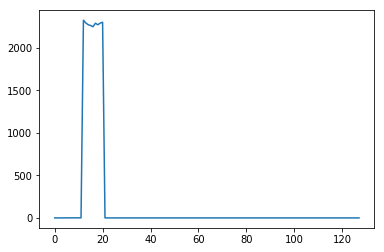

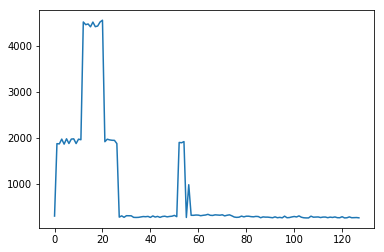

In [789]:
dice = np.random.randint(len(kettle_signatures))
print(dice)
plt.plot(kettle_signatures[dice])
plt.show()
plt.plot(kettle_aggregates[dice])
plt.show()

In [822]:
kettle_signatures_pd = pd.DataFrame(kettle_signatures, columns = np.linspace(0,1,128))
kettle_signatures_pd.head()

,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [823]:
kettle_aggregates_pd = pd.DataFrame(kettle_aggregates, columns = np.linspace(0,1,128))
kettle_aggregates_pd.head()

,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,193.0,191.0,195.0,194.0,190.0,193.0,193.0,191.0,194.0,196.0,...,348.0,372.0,344.0,374.0,359.0,363.0,367.0,354.0,355.0,359.0
1,521.0,519.0,556.0,519.0,521.0,523.0,1985.0,2024.0,518.0,503.0,...,650.0,656.0,651.0,645.0,639.0,647.0,651.0,646.0,641.0,639.0
2,146.0,143.0,145.0,143.0,143.0,144.0,146.0,144.0,143.0,144.0,...,197.0,199.0,197.0,198.0,195.0,196.0,201.0,195.0,195.0,193.0
3,162.0,165.0,164.0,164.0,165.0,164.0,163.0,163.0,165.0,164.0,...,164.0,165.0,164.0,163.0,165.0,356.0,347.0,362.0,349.0,2637.0
4,435.0,425.0,461.0,455.0,163.0,165.0,165.0,163.0,166.0,163.0,...,488.0,496.0,501.0,499.0,469.0,476.0,480.0,477.0,465.0,463.0


In [786]:
signals_pd = pd.DataFrame(signals, columns = ['start','end'])
signals_pd.head()

,start,end
0,2012-11-10 08:49:36,2012-11-10 08:51:51
1,2012-11-10 17:22:34,2012-11-10 17:24:11
2,2012-11-11 08:28:35,2012-11-11 08:30:53
3,2012-11-11 11:35:03,2012-11-11 11:38:15
4,2012-11-11 11:44:29,2012-11-11 11:47:05


In [806]:
kettle_signatures_test_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2971.0,2982.0,2988.0,2931.0,2993.0,3001.0,2975.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2887.0,2876.0,2847.0,2867.0,2848.0,2861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [825]:
kettle_signatures_pd.to_csv('../../master_data/nilm/kettle_signatures.dat', sep = ' ')
kettle_aggregates_pd.to_csv('../../master_data/nilm/kettle_input.dat', sep = ' ')
signals_pd.to_csv('../../master_data/nilm/kettle_signals.dat', sep = ' ')

In [824]:
kettle_signatures_test_pd = pd.DataFrame(kettle_signatures_test, columns = np.linspace(0,1,128))
kettle_aggregates_test_pd = pd.DataFrame(kettle_aggregates_test, columns = np.linspace(0,1,128))
signals_test_pd = pd.DataFrame(signals_test)

In [826]:
kettle_signatures_test_pd.to_csv('../../master_data/nilm/kettle_signatures_test.dat', sep = ' ')
kettle_aggregates_test_pd.to_csv('../../master_data/nilm/kettle_input_test.dat', sep = ' ')
signals_test_pd.to_csv('../../master_data/nilm/kettle_signals_test.dat', sep = ' ')

## Syntethic data
Given the exceptionally good classification results in the rectangle experiment, it is tempting to leave out data points not containing a signal, however this may decrease the robustness of the model.

In [488]:
def clean_power_series(aggregate_power, signal_intervals):
    #aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')
    #signal_intervals['start'] = pd.to_datetime(signal_intervals['start'],unit='s')
    #signal_intervals['end'] = pd.to_datetime(signal_intervals['end'],unit='s')
    
    temp_ap = aggregate_power.copy()
    
    n = signal_intervals.shape[0]

    pcent = int(n/100)
    ap_sans_application = pd.DataFrame()
    
    ap_sans_application.append(temp_ap[:signal_intervals['start'][0]])
    
    for i in range(1,n):
        if i % pcent == 0:
            print(str(i/pcent) + '%')
        ap_sans_application = ap_sans_application.append(temp_ap[signal_intervals['end'][i-1]:signal_intervals['start'][i]])
    
    ap_sans_application.append(temp_ap[signal_intervals['end'][i]:])
    
    return ap_sans_application

        
def make_syntethic_data(aggregate_power, signal_intervals, app_signatures, n = 10000,
                        ap_sans_application = None, sample_length = 128):
    
    if ap_sans_application is None:
        ap_sans_application = clean_power_series(aggregate_power, signal_intervals)
    
    sign_len = len(app_signatures)
    
    syntethic_data = pd.DataFrame(columns=np.linspace(0,1,sample_length))
    syntethic_response = pd.DataFrame(columns=np.linspace(0,1,sample_length))
    
    pcent = n/100
    
    
    for i in range(n):
        
        if i % pcent == 0:
            print(i/pcent)
        
        syntethic_response.loc[i] = [0 for _ in range(sample_length)]
        dice = np.random.random()
        
        app_no = np.random.randint(0,sign_len-1)
        sample_start = np.random.randint(0,ap_sans_application.shape[0]-(sample_length+1))
        sample_end = sample_start + sample_length - 1
        
        sample_start_time = ap_sans_application.index[sample_start]
        sample_end_time = ap_sans_application.index[sample_end] 
        
        sample = ap_sans_application.loc[sample_start_time:sample_end_time]
        signal = app_signatures.loc[app_no].dropna()
    
        if dice > 0.5:
            signal_start = np.random.randint(0,sample_length - (signal.shape[0] + 1))
            signal_end = signal_start + signal.shape[0]
            
            sample.iloc[signal_start:signal_end] = sample.iloc[signal_start:signal_end].values[0] + signal.values
            
            signal_start_time = sample.index[signal_start]
            signal_end_time = sample.index[signal_end]
            
            start_fraction = (signal_start_time - sample.index[0])/(sample.index[-1] - sample.index[0])
            end_fraction = (signal_end_time - sample.index[0])/(sample.index[-1] - sample.index[0])

            syntethic_data.loc[i] = sample.T.values[0]
            syntethic_response.loc[i].iloc[signal_start:signal_end] = signal.values
        
        else:
            syntethic_data.loc[i] = sample.T.values[0]
            #syntethic_response.loc[i] = [0 for _ in range(sample_length)]
            
    return syntethic_data, syntethic_response
    

In [209]:
clean_data = clean_power_series(house1_aggregate,signals_pd)

1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


In [290]:
house1_aggregate['Power'] = house1_aggregate['Power'].astype(np.float64)
kettle_signatures_pd = kettle_signatures_pd.astype(np.float64)

In [503]:
syntethic_kettle_data, syntethic_kettle_response = make_syntethic_data(house1_aggregate, signals_pd,
                                                                       kettle_signatures_pd,n=10000,
                                                                       ap_sans_application = clean_data)

0.0


/home/bjornif/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0


False
False


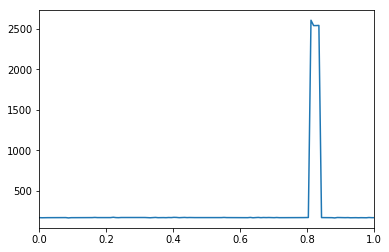

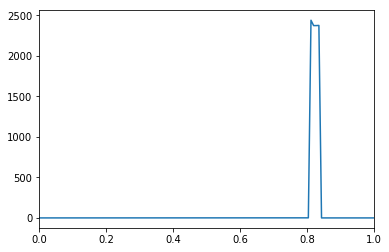

In [813]:
print(syntethic_kettle_data.isnull().any(axis=1).any())
print(syntethic_kettle_response.isnull().any(axis=1).any())
dice = np.random.randint(0,syntethic_kettle_data.shape[0])
syntethic_kettle_data.loc[dice].plot()
plt.show()
syntethic_kettle_response.loc[dice].plot()
plt.show()

In [821]:
syntethic_kettle_response.head()

,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [814]:
syntethic_kettle_data.to_csv('../../master_data/nilm/syntethic_kettle_dae.dat', sep = ' ')
syntethic_kettle_response.to_csv('../../master_data/nilm/syntethic_kettle_dae_response.dat', sep = ' ')